# LPPUFv1 Bias Analysis

In [1]:
import numpy as np
import pypuf.batch
import pypuf.metrics

from lppuf import LPPUFv1

In [2]:
import logging

logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [3]:
%%bash
#rm -rf results/v1/uniqueness
mkdir -p results/v1/bias

In [4]:
results = pypuf.batch.FilesystemResultCollection('results/v1/bias')

In [5]:
class LPPUFv1BiasAnalysis(pypuf.batch.StudyBase):
    
    def parameter_matrix(self):
        return [
            dict(
                n=n,
                noisiness_1=noisiness_1,
                noisiness_2=noisiness_2,
                num=num,
                seed=seed,
                m=m,
            )
            for n in [64]
            for noisiness_1 in [0] # .01,.02,.05,.1, .2, .35, .5]
            for noisiness_2 in [0] # .01,.02,.05,.1, .2, .35, .5]
            for num in [10]
            for seed in range(100)
            for m in [2, 4, 8, 16]
        ]
    
    def run(self, n, noisiness_1, noisiness_2, num, m, seed):
        puf = LPPUFv1(
            n=n, m=m, noisiness_1=noisiness_1, noisiness_2=noisiness_2, 
            seed=pypuf.simulation.base.Simulation.seed(f"LP-PUF Bias Experiment Seed {seed}"),
        )
        layer3_puf = puf.layer[2]
        return {
            'b': pypuf.metrics.bias(puf, seed=31415, N=10000),
            'b3': pypuf.metrics.bias(layer3_puf, seed=31415, N=10000),
        } 

In [6]:
study = LPPUFv1BiasAnalysis(results)

In [7]:
study.run_all()

DEBUG:root:LPPUFv1BiasAnalysis: running 0 unfinished jobs from a batch of 400 (400 of this batch already completed, batch total 400, study total 400 jobs)


In [8]:
import pandas as pd

In [9]:
data = pd.DataFrame(results.load_all())

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
data['LP-PUF'] = data['b']
data['Layer 3'] = data['b3']

In [12]:
melted_data = data[data.iloc[0]['parameters'] + ['LP-PUF', 'Layer 3']].melt(
    id_vars=['n', 'noisiness_1', 'noisiness_2', 'num', 'seed', 'm'],
    var_name=['component'],
    value_name='bias',
)

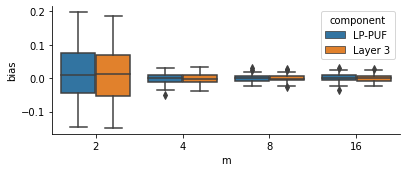

In [14]:
sns.catplot(
    x='m', 
    y='bias', 
    #row='noisiness_1', 
    #col='noisiness_2', 
    hue='component', 
    data=melted_data,
    kind='box',
    aspect=2.3/1,
    height=2.5,
    legend_out=False,
)
plt.tight_layout()
plt.savefig('figures/lppufv1-bias.pdf')